<a href="https://colab.research.google.com/github/msimuko/code-unza25-csc4792-project_team_30/blob/main/code_unza25_csc4792_project_team_30_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.3.2 References Publication Type Classification (CRISP-DM)
##Business understanding: Reference Classification Project

### Overview
This project develops an automated system to classify academic references by publication type using machine learning techniques. The system can distinguish between journals, books, theses, conference papers, and other publication formats, helping researchers and librarians organize academic literature more efficiently.

### Business Understanding

### Problem Statement  
Managing and organizing academic references is a time-consuming process for students, researchers, and librarians. Manually categorizing references into types such as journal articles, books, theses, conference papers, reports, and web resources is error-prone and inconsistent, especially when dealing with large bibliographies. This lack of automation reduces productivity and creates difficulties in maintaining standardized reference databases at the University of Zambia.  

---

## Business Objectives  
The project seeks to automate the classification of academic references into their correct publication types.  

**Practical Success means:**  
- Students and researchers spend less time categorizing references manually.  
- Librarians can easily maintain structured institutional repositories.  
- The system provides fast, accurate, and consistent classification regardless of reference style (APA, IEEE, etc.).  
- A user-friendly interface (Streamlit app) is available for anyone to input a reference and receive an instant classification.  

---

## Data Mining Goals  
To achieve the above objectives, the project will:  
- Build a **classification model** that automatically predicts the type of reference (Journal, Book, Thesis, Conference, Report, Web) based on its textual structure.  
- Apply **TF-IDF feature extraction** on textual data to transform references into numerical representations suitable for machine learning.  
- Train and evaluate machine learning models (e.g., Naive Bayes, Logistic Regression, or SVM) to determine the best-performing classifier.  
- Deploy the trained model in a **Streamlit web application** for real-time use.  

---

## Initial Project Success Criteria  
- **Technical Success:**  
  - The model should achieve at least **80% classification accuracy** on test data.  
  - Classification reports (precision, recall, F1-score) must show balanced performance across all categories.  
- **Business/Practical Success:**  
  - The tool should classify new references **within 2 seconds** per input.  
  - The Streamlit interface must be simple enough for **non-technical users** to operate without training.  
  - At least **five reference types** must be reliably classified.  


## Publication Types
The model classifies references into the following categories:
- **Journal Articles**: Peer-reviewed academic papers
- **Books**: Monographs and edited volumes
- **Thesis/Dissertations**: Graduate research works
- **Conference Papers**: Proceedings and presentations
- **Technical Reports / Reports**: Government and institutional publications
- **Web Resources**: Online publications and documents

> **Note:** The project and app support both "Report" and "Technical Report" as valid types.

## Tools and Technologies
- **Python 3.8+**: Primary programming language
- **Pandas**: Data manipulation and analysis
- **Scikit-learn**: Machine learning framework
- **TF-IDF Vectorizer**: Text feature extraction
- **Multinomial Naive Bayes**: Classification algorithm
- **Jupyter Notebook**: Development and experimentation environment
- **NumPy**: Numerical computations
- **Matplotlib/Seaborn**: Data visualization (optional)

## Project Structure
```
project-root/
├── data/
│   └── references.csv                  # Labeled training data
├── notebooks/
│   └── classification_model.ipynb     # Main ML pipeline
├── src/
│   └── utils.py                       # Text preprocessing functions
├── report/
│   └── draft.pdf                      # Technical documentation
├── slides/
│   └── presentation.pptx              # Project presentation
└── README.md                          # This file
```

## Data Format
The `references.csv` file should contain two columns:
- `reference_text`: Full bibliographic reference as text
- `publication_type`: Category label (journal, book, thesis, etc.)

Example:
```csv
reference_text,publication_type
"Smith, J. (2023). Machine Learning in Academia. Journal of AI Research, 15(3), 45-67.",journal
"Johnson, A. (2022). Deep Learning Fundamentals. MIT Press, Cambridge.",book
```

## Installation and Setup
1. **Clone or download** the project files
2. **Install required packages**:
   ```bash
   pip install pandas scikit-learn jupyter numpy
   ```
3. **Prepare your data**: Place labeled references in `data/references.csv`
4. **Launch Jupyter**:
   ```bash
   jupyter notebook notebooks/classification_model.ipynb
   ```

## Usage Instructions
1. **Data Preparation**: Ensure your reference data is properly formatted in CSV
2. **Text Cleaning**: The `utils.py` module handles preprocessing automatically
3. **Model Training**: Execute all cells in the Jupyter notebook sequentially
4. **Evaluation**: Review the classification report and confusion matrix
5. **Prediction**: Use the trained model to classify new references

## Model Performance
The system uses TF-IDF (Term Frequency-Inverse Document Frequency) for feature extraction combined with Multinomial Naive Bayes for classification. Expected performance metrics:
- **Accuracy**: 85-92% (depending on data quality)
- **Precision**: High for well-represented classes
- **Recall**: Varies by publication type complexity
- **F1-Score**: Balanced performance across categories

## Key Features
- **Robust Text Preprocessing**: Handles various reference formats
- **Feature Engineering**: TF-IDF with n-grams (1-2) for better context
- **Scalable Pipeline**: Easy to retrain with new data
- **Performance Analysis**: Comprehensive evaluation metrics
- **Extensible Design**: Simple to add new publication types



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Understanding

The dataset for this project is located in `data/references.csv` and consists of academic references from the UNZA Institutional Repository. Each entry includes:
- `reference_text`: The full bibliographic reference as a string.
- `publication_type`: The manually assigned category label (e.g., Journal Article, Book, Thesis, Conference Paper, Report, Web Resource).

**Initial Data Exploration:**
- The dataset contains 9 references, each labeled with one of six publication types.
- All entries have both required columns and no missing values.
- The class distribution is as follows:
  - Journal Article: 1
  - Book: 2
  - Thesis: 2
  - Conference Paper: 1
  - Report: 2
  - Web Resource: 1

**Observations:**
- The dataset is small and imbalanced, with some classes represented by only one sample.
- Reference texts vary in length and format, reflecting real-world diversity.
- No duplicate entries or obvious data quality issues were found.
- Text preprocessing (see `src/utils.py`) is used to standardize and clean reference strings before modeling.

**Implications for Modeling:**
- The limited and imbalanced data may affect model generalization and accuracy.
- Stratified train-test splitting may not be possible for all classes; random splitting is used when necessary.
- Additional data collection is recommended for improved performance and robustness.

In [ ]:
!ls /content


drive  sample_data


###Step 1: Access UNZA IR and list ETDs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Step 1: references.csv data extraction from unza institutional repository into references.csv



In [ ]:
!pip install requests pandas pymupdf
!pip install tools
!pip install pdfplumber    # Recommended
!pip install pypdf
!pip install requests
!pip install beautifulsoup4
!pip install lxml
!pip install pdfplumber
!pip install pypdf
!pip install PyMuPDF


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 8.3 MB/s eta 0:00:00


In [ ]:
# =======================
# Mount Google Drive
# =======================
from google.colab import drive
drive.mount('/content/drive')

# =======================
# Install required packages (no-ops if present)
# =======================
!pip install -q requests beautifulsoup4 lxml pdfplumber pypdf PyMuPDF

# =======================
# Imports
# =======================
import requests, pandas as pd, time, io, os, hashlib
from typing import Dict, List, Set, Tuple
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup
from datetime import datetime
from requests.adapters import HTTPAdapter, Retry

# =======================
# HTTP session with retries
# =======================
session = requests.Session()
retries = Retry(total=3, backoff_factor=0.5, status_forcelist=[429,500,502,503,504])
session.mount("http://", HTTPAdapter(max_retries=retries))
session.mount("https://", HTTPAdapter(max_retries=retries))
HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; UNZA-RefCrawler/1.0)"}

# =======================
# PDF library detection
# =======================
PDF_LIBRARY = None
try:
    import pdfplumber
    PDF_LIBRARY = "pdfplumber"
    print("Using pdfplumber for PDF text extraction")
except Exception:
    try:
        from pypdf import PdfReader
        PDF_LIBRARY = "pypdf"
        print("Using pypdf for PDF text extraction")
    except Exception:
        try:
            import fitz  # PyMuPDF
            PDF_LIBRARY = "pymupdf"
            print("Using PyMuPDF for PDF text extraction")
        except Exception:
            raise ImportError("Install pdfplumber or pypdf or PyMuPDF")

# =======================
# Helpers
# =======================
def md5(b: bytes) -> str:
    return hashlib.md5(b).hexdigest()

def extract_text_from_pdf(pdf_bytes: bytes) -> str:
    try:
        if PDF_LIBRARY == "pdfplumber":
            with pdfplumber.open(io.BytesIO(pdf_bytes)) as pdf:
                text = "\n".join((p.extract_text() or "") for p in pdf.pages)
            return text.strip() or "No text found"
        elif PDF_LIBRARY == "pypdf":
            from pypdf import PdfReader
            reader = PdfReader(io.BytesIO(pdf_bytes))
            text = "\n".join((p.extract_text() or "") for p in reader.pages)
            return text.strip() or "No text found"
        else:
            import fitz
            doc = fitz.open(stream=pdf_bytes, filetype="pdf")
            text = "".join(page.get_text() for page in doc)
            doc.close()
            return text.strip() or "No text found"
    except Exception as e:
        return f"Error extracting text: {e}"

def looks_like_pdf_url(href: str) -> bool:
    href_l = href.lower()
    return (".pdf" in urlparse(href_l).path) or (".pdf" in href_l)

def is_pdf_response(resp: requests.Response, content: bytes) -> bool:
    ctype = resp.headers.get("content-type","").lower()
    return ("pdf" in ctype) or content.startswith(b"%PDF-")

# =======================
# Spider
# =======================
class Spider:
    def __init__(self, start_urls: List[str], allowed_host: str = "datalab.unza.zm", max_depth: int = 2, max_pdfs: int = 50):
        self.queue: List[Tuple[str,int]] = [(u,0) for u in start_urls]
        self.queued: Set[str] = set(start_urls)
        self.visited: Set[str] = set()
        self.allowed_host = allowed_host.lower()
        self.max_depth = max_depth
        self.skip_exts = {".jpg",".jpeg",".png",".gif",".css",".csv",".xls",".xlsx",".log",".ps",".xmp",".svg",".zip",".rar",".7z",".tar",".gz"}
        self.pdfs: Dict[str, bytes] = {}
        self.max_pdfs = max_pdfs
        self.pdf_count = 0

    def same_site(self, url: str) -> bool:
        host = urlparse(url).netloc.lower()
        return host == self.allowed_host or host.endswith("." + self.allowed_host)

    def should_follow_html(self, url: str) -> bool:
        path = urlparse(url).path
        ext = os.path.splitext(path)[1].lower()
        return (ext == "" or ext == "/" or ext not in self.skip_exts) and self.same_site(url)

    def enqueue(self, url: str, depth: int):
        if url not in self.queued and url not in self.visited:
            self.queue.append((url, depth))
            self.queued.add(url)

    def fetch(self, url: str) -> requests.Response | None:
        try:
            return session.get(url, headers=HEADERS, timeout=20, allow_redirects=True, verify=False)
        except Exception as e:
            print(f"FAILED {url}: {e}")
            return None

    def handle_html(self, base_url: str, html: str, depth: int):
        soup = BeautifulSoup(html, "lxml")
        for a in soup.find_all("a", href=True):
            if self.pdf_count >= self.max_pdfs:
                return
            abs_url = urljoin(base_url, a["href"])

            # PDFs
            if looks_like_pdf_url(abs_url):
                if abs_url in self.pdfs:
                    continue
                resp = self.fetch(abs_url)
                if not resp:
                    continue
                content = resp.content or b""
                if is_pdf_response(resp, content):
                    self.pdfs[abs_url] = content
                    self.pdf_count += 1
                    print(f"📄 Found PDF ({self.pdf_count}/{self.max_pdfs}): {abs_url}")
                    if self.pdf_count >= self.max_pdfs:
                        return
                continue

            # HTML pages
            if depth < self.max_depth and self.should_follow_html(abs_url):
                self.enqueue(abs_url, depth+1)

        next_link = soup.find("a", rel=lambda v: v and "next" in v.lower())
        if next_link and next_link.get("href") and depth < self.max_depth:
            self.enqueue(urljoin(base_url, next_link["href"]), depth+1)

    def crawl(self):
        while self.queue and self.pdf_count < self.max_pdfs:
            url, depth = self.queue.pop()
            if url in self.visited:
                continue
            self.visited.add(url)
            resp = self.fetch(url)
            if not resp:
                continue
            ctype = resp.headers.get("content-type","").lower()
            if "text/html" in ctype:
                self.handle_html(url, resp.text, depth)
            elif "pdf" in ctype or (resp.content or b"").startswith(b"%PDF-"):
                if url not in self.pdfs and self.pdf_count < self.max_pdfs:
                    self.pdfs[url] = resp.content
                    self.pdf_count += 1
                    print(f"📄 Found PDF ({self.pdf_count}/{self.max_pdfs}): {url}")
            print(f"Crawled (depth {depth}): {url}")
            time.sleep(0.7)

# =======================
# Run crawl
# =======================
start_urls = [
    "https://datalab.unza.zm/publications/conference-papers",
    "https://datalab.unza.zm/publications/journal-articles",
    "https://datalab.unza.zm/index.php/publications/technical-reports",
    "https://datalab.unza.zm/publications/theses-and-dissertations",
]

spider = Spider(start_urls, allowed_host="datalab.unza.zm", max_depth=2, max_pdfs=50)
spider.crawl()

# =======================
# Save PDFs + CSV (Data Selection + Preprocessing + Transformation)
# =======================
save_pdf_dir = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/pdfs"
os.makedirs(save_pdf_dir, exist_ok=True)

rows = []
for i, (pdf_url, pdf_bytes) in enumerate(spider.pdfs.items(), 1):
    print(f"Processing {i}/{len(spider.pdfs)}: {pdf_url}")
    text = extract_text_from_pdf(pdf_bytes)
    meta = {
        "PDF_URL": pdf_url,
        "File_Size": len(pdf_bytes),
        "MD5": md5(pdf_bytes),
        "Timestamp": datetime.now().isoformat(),
        "Extracted_Text": text,
    }
    rows.append(meta)
    pdf_path = os.path.join(save_pdf_dir, f"{meta['MD5']}.pdf")
    if not os.path.exists(pdf_path):
        with open(pdf_path, "wb") as f:
            f.write(pdf_bytes)

df = pd.DataFrame(rows)
csv_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references.csv"
# Ensure the directory exists before saving the CSV
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
df.to_csv(csv_path, index=False)
print(f" Saved {len(df)} PDFs and metadata to {csv_path}")

# =======================
# Extended Data Preparation (Derivation, Integration, Dataset Description)
# =======================

# --- Data Derivation ---
df["Num_Words"] = df["Extracted_Text"].apply(lambda t: len(str(t).split()))
df["Num_Chars"] = df["Extracted_Text"].apply(lambda t: len(str(t)))
df["Domain"] = df["PDF_URL"].apply(lambda u: urlparse(u).netloc)
df["File_Name"] = df["PDF_URL"].apply(lambda u: os.path.basename(urlparse(u).path))

# --- Data Integration / Merging ---
# Example: merge with external metadata (simulated here)
extra_meta = pd.DataFrame([
    {"Domain": "datalab.unza.zm", "Source_Type": "UNZA Datalab"}
])
df = df.merge(extra_meta, on="Domain", how="left")

# --- Dataset Description ---
print("\n Dataset Description:")
print(df.describe(include="all").transpose())

# Save enriched dataset
enriched_csv_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_enriched.csv"
# Ensure the directory exists before saving the enriched CSV
os.makedirs(os.path.dirname(enriched_csv_path), exist_ok=True)
df.to_csv(enriched_csv_path, index=False)
print(f" Enriched dataset saved to {enriched_csv_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using pdfplumber for PDF text extraction


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 0): https://datalab.unza.zm/publications/theses-and-dissertations


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/people


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/monicanakazwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/noreenmwelwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chishamwansa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lwiindimudimba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/treasurechisakula


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/doramayaka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/norahndebele


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/freebornlubasi


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/nozyenjimwale


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/nandisikazindu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/moongahabukali


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mathewsmwewa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mathewsmbewe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/daisynawila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/philomenamwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/andrewmawila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ericliswaniso


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/berthachipangila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mwenyakayula


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mirriamkamanga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/elizabethchirwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mulengachanda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/jeffersonndhlovu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mwangalanzila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mutunechaibela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/inutulubinda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chengomapoma


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/macmillanmamamba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/dannysiabbaba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/matthewslungu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/davidpungwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/sharonkangwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ivychisha


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/victormwelwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/roycemwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lewisntembeni


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/bydonsimukoko


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/emmanuelkuyela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/wilkinssikazwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/richardmufuzi


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/johnmwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/rectornjobvu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/hazelbowa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lindamwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/blessedmakungu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/brightonmwaba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/prudencebule


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/prudencemwendaluta


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/nkolemulenga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/geoffreyngoma


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/towelakalikeka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/maindachuulu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/memoryphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/kamfwachileshe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chandachilufya


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/emmanuelphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/castridahnachibinga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ernestsinyangwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chabunamwila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/austinmonde


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/petertembo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/martinkambunji


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/patrickmwila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/joemwape


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lweendomuzyamba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chandachisanga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/christabelchalwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/setwellmuleya


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lwimeshansonga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/albertinahmooka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/peterdaka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lloydhangoma


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/davidtembo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/giftmuwele


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/kangwamukuka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/alicephiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chiyembekezokondwanidaka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/thofaimtonga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/marvislungu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/amosmapili


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mulengakatongo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/festusmwape


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/kadeyokuyela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/robertmsendo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/angelabanda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/dokowetembo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/violetchama


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/matildahmuchinga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ceciliakasonde


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/adrianchisale


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/henrymwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/martinmusonda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/annettemulenga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/elijahchileshe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/malaizyomuzumala


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/angelanyirenda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/henrysimunguzye


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chisomosingogo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/petrosndumba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ennetysiwila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/frazernyambe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/harrisshikapande


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mubangachibesa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/peterchibuta


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ernestzulu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lightonphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/rabsonmbewe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/contact


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/past-members


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/current-members


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/services


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.rda.org.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (1/50): https://www.rda.org.zm/wp-content/uploads/2023/09/THE-ROAD-TRAFFIC-ACT-2002.pdf
Crawled (depth 2): https://datalab.unza.zm/projects/road-safety-in-zambia


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.parliament.gov.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (2/50): https://www.parliament.gov.zm/sites/default/files/documents/pages/Strategic%20Plan%202022-2026.pdf
Crawled (depth 2): https://datalab.unza.zm/projects/legal-and-legislative-documents


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects/wikipedia-in-the-global-south


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects/educational-data-mining


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects/zambia-national-etd-portal


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects/enterprise-medical-imaging


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/technical-reports


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/capstone-project-reports


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/books


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/research/technology-enhanced-learning


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/research/digital-libraries


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/research/data-mining


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/projects


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (3/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-ijmso21-ir_reclassification.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/20


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (4/50): https://datalab.unza.zm/sites/default/files/2022-05/papers-jcdl21-ir_controlled_vocabularies.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/28


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (5/50): https://datalab.unza.zm/sites/default/files/2023-08/paper-etd22-etdms_compliance.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/42


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (6/50): https://datalab.unza.zm/sites/default/files/2023-12/paper-etd23-assessing_and_promoting_metadata_quality_using_policies.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/47


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (7/50): https://datalab.unza.zm/sites/default/files/2023-12/paper-etd23-towards_metadata_completeness_for_improved_discoverability.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/46


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (8/50): http://41.63.1.14/sites/default/files/2022-05/paper-ista22-emi_opportunities_and_challenges.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/37


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (9/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza23-ict4014-monde_mwila_namwila_tembo_2.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/50


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (10/50): https://datalab.unza.zm/sites/default/files/2023-12/paper-icict23-software_tools_for_supporting_automatic_image_interpretation.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/49


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (11/50): https://datalab.unza.zm/sites/default/files/2023-12/paper-icict23-large_scale_image_analysis.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/48


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (12/50): https://datalab.unza.zm/sites/default/files/2023-12/papers-mtsr23-radiology_report_terminologies.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/43


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/research


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/prudencemwendaluta


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/hazelbowa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/jeffersonndhlovu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mwangalanzila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/inutulubinda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chengomapoma


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/macmillanmamamba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/matthewslungu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/monicanakazwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/noreenmwelwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chishamwansa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/lwiindimudimba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/treasurechisakula


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mwenyakayula


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mirriamkamanga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/elizabethchirwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mulengachanda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/kadeyokuyela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ennetysiwila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chiyembekezokondwanidaka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/amosmapili


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/maindachuulu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/memoryphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/kamfwachileshe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chandachilufya


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/prudencebule


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/emmanuelkuyela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/lindamwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/blessedmakungu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/henrymwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/angelabanda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ceciliakasonde


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/daisynawila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/philomenamwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/andrewmawila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ericliswaniso


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/berthachipangila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/nozyenjimwale


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/nandisikazindu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/moongahabukali


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mathewsmwewa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mathewsmbewe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/sharonkangwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/victormwelwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chisomosingogo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/setwellmuleya


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/lwimeshansonga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/harrisshikapande


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/davidtembo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mubangachibesa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/giftmuwele


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/emmanuelphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/castridahnachibinga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ernestsinyangwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/martinkambunji


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/joemwape


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/lweendomuzyamba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chandachisanga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/christabelchalwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/martinmusonda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/annettemulenga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/bydonsimukoko


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/nkolemulenga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/geoffreyngoma


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ernestzulu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/richardmufuzi


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/frazernyambe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mutunechaibela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/dannysiabbaba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/davidpungwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ivychisha


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/adrianchisale


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/robertmsendo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/research#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (13/50): http://41.63.1.14/sites/default/files/2022-06/etds-uct13-simple_digital_libraries.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/13


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/13


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/7


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/27


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/18


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/13#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (14/50): https://datalab.unza.zm/sites/default/files/2022-06/etds-uct18-streamlined_orchestration_0.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/26


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/25


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/5#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (15/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-msc-dissertation-robert_m%27sendo.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/61


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/61


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/77


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/61#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (16/50): https://datalab.unza.zm/sites/default/files/2022-05/etds-unza22-kuyela-interactive_tablets.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/38


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/38


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/72


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/38#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (17/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-pdip-dissertation-elijah_chileshe.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/66


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/export/bibtex/bibcite_reference/66


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/48


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/66#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (18/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-pdip-dissertation-andrew_shawa.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/65


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/export/bibtex/bibcite_reference/65


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/107


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/65#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/59


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/59


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/80


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/59#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (19/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-adrian_chisale.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/58


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/58


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/156


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/81


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/58#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (20/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-matildah_muchinga_0.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/64


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/64


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/132


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/64#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (21/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-dokowe_tembo_0.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/60


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/export/bibtex/bibcite_reference/60


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/129


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/60#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/publications


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=6


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=4


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (22/50): https://datalab.unza.zm/sites/default/files/2024-06/paper-saicsit24-wikimotivate_facebook_plugin.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/63


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (23/50): https://datalab.unza.zm/sites/default/files/2024-06/paper-emiz24-pacs_prototype_usefulness_evaluation.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/62


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (24/50): http://41.63.1.14/sites/default/files/2025-04/reports-unza24-ict4014-daka_hangoma_tembo_shikapande.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/69


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (25/50): https://datalab.unza.zm/sites/default/files/2025-04/paper-saicsit24-wikimotivate_facebook_plugin.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/68


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/70


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (26/50): https://datalab.unza.zm/sites/default/files/2025-04/paper-emiz24-medical_image_interpretation_evaluation.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/67


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/71


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=7


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=6


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=4


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/articles/andrew-shawa-delivers-insightful-talk-intelligent-dicom-viewers-academicindustry


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/articles/user-centered-design-and-implementation-useful-picture-archiving-and-communication-systems


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/articles/emiz-team-participating-data-science-africa-2024-workshop-and-summer-school-0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/articles/our-research-wikipedia-content-contribution-zambia-featured-wikimedia-research-showcase


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/articles/new-postgraduate-students-joining-datalab-research-group-2025


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/70


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/68


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/71


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/contact


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/contact#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/people/past-members


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/past-members#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/people/current-members


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/current-members#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/people


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/services


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/services#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/road-safety-in-zambia


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/69


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/road-safety-in-zambia#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/legal-and-legislative-documents


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (27/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza23-ict4014-kambunji_phiri_nachibinga_sinyangwe.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/55


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/lightonphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/legal-and-legislative-documents#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/wikipedia-in-the-global-south


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (28/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza23-ict4014-chalwe_chanda_muzyamba_mwape.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/45


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/wikipedia-in-the-global-south#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/educational-data-mining


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (29/50): https://datalab.unza.zm/sites/default/files/2022-06/reports-unza18-lis4014-chisakula_mudimba_mwansa_mwelwa_nakazwe.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/22


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (30/50): https://datalab.unza.zm/sites/default/files/2022-06/reports-unza21-ict4014-chaibela_chisha_pungwa_siabbaba_simukoko.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/31


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/educational-data-mining#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/zambia-national-etd-portal


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/zambia-national-etd-portal?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/zambia-national-etd-portal?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/20


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/28


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/42


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/47


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/46


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/zambia-national-etd-portal#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/enterprise-medical-imaging


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/enterprise-medical-imaging?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/enterprise-medical-imaging?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/enterprise-medical-imaging#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/theses-and-dissertations


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/theses-and-dissertations#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/journal-articles


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/10


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (31/50): http://41.63.1.14/sites/default/files/2022-05/papers-etd19-multifaceted_approach.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/8


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/41


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/journal-articles#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/conference-papers


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/conference-papers?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/conference-papers?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/conference-papers?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/48


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/43


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/49


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (32/50): https://datalab.unza.zm/sites/default/files/2023-12/paper-africhi23-portal_usability_evaluation.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/57


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/conference-papers#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/capstone-project-reports


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/capstone-project-reports?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/capstone-project-reports?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (33/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza22-ict4014-bowa_mwendaluta_kalikeka_njobvu.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/54


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (34/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza22-ict4014-bule_kuyela_makungu_mwanza.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/53


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (35/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza22-ict4014-nyambe_mulenga_mufuzi_ngoma.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/52


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (36/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza22-ict4014-mwaba_mwanza_shawa_sikazwe.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/51


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (37/50): http://41.63.1.14/sites/default/files/2023-12/reports-unza23-ict4014-chanda_kanfwa_mainda.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/56


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (38/50): http://41.63.1.14/sites/default/files/2023-12/reports-unza23-ict4014-kambunji_phiri_nachibinga_sinyangwe.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/55


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/capstone-project-reports#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/books


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/12


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/books#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=6


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=4


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/research/technology-enhanced-learning


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (39/50): https://datalab.unza.zm/sites/default/files/2022-06/reports-unza20-lis4014-chanda_chirwa_kamanga_kayula.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/7


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (40/50): https://datalab.unza.zm/sites/default/files/2022-06/reports-unza21-ict4014-chengo_hamamba_mubanga_nzila_simfukwe.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/33


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (41/50): https://datalab.unza.zm/sites/default/files/2022-06/reports-unza21-ict4014-mambwe_lubinda_ndhlovu_ntembeni_lungu.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/32


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/31


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (42/50): https://datalab.unza.zm/sites/default/files/2022-05/papers-csedu22-factors_influencing_cocreation_of_oers.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/34


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/technology-enhanced-learning#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/research/digital-libraries


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/4


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/8


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/digital-libraries#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/research/data-mining


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/data-mining?page=3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/data-mining?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/data-mining?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/data-mining?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/data-mining#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/research


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=7


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=6


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=4


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/publications/theses-and-dissertations#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 0): https://datalab.unza.zm/index.php/publications/technical-reports


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (43/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-uct13-benchmarking_file_based_digital_libraries.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/15


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/export/bibtex/bibcite_reference/15


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/15#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (44/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-report14-automatic_workflow_management.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/17


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/17


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/32


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/31


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/13


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/17#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (45/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-uct17-rvoa_oer_feasibility.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/export/bibtex/bibcite_reference/3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/keyword/15


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/keyword/14


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/38


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/8


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/74


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/7


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/3#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (46/50): https://datalab.unza.zm/sites/default/files/2022-05/reports-unza21-enterprise_medical_imaging_in_zambia.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/29


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/29


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/24


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/23


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/22


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/38


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/46


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/29#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/technical-reports#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 0): https://datalab.unza.zm/publications/journal-articles


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/publications/journal-articles#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 0): https://datalab.unza.zm/publications/conference-papers


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/publications/conference-papers?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (47/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-saicsit11-simplyct.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/39


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (48/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-icadl12-bonolo.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (49/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-decidoc12-in_search_of_simplicity.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/6


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (50/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-saicsit13-flexible_digital_libraries.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/14
Processing 1/50: https://www.rda.org.zm/wp-content/uploads/2023/09/THE-ROAD-TRAFFIC-ACT-2002.pdf
Processing 2/50: https://www.parliament.gov.zm/sites/default/files/documents/pages/Strategic%20Plan%202022-2026.pdf
Processing 3/50: https://datalab.unza.zm/sites/default/files/2022-06/papers-ijmso21-ir_reclassification.pdf
Processing 4/50: https://datalab.unza.zm/sites/default/files/2022-05/papers-jcdl21-ir_controlled_vocabularies.pdf
Processing 5/50: https://datalab.unza.zm/sites/default/files/2023-08/paper-etd22-etdms_compliance.pdf
Processing 6/50: https://datalab.unza.zm/sites/default/files/2023-12/paper-etd23-assessing_and_promoting_metadata_quality_using_policies.pdf
Processing 7/50: https://datalab.unza.zm/sites/default/files/2023-12/paper-etd23-towards_metadata_completeness_for_improved_discover

Processing 17/50: https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-pdip-dissertation-elijah_chileshe.pdf
Processing 18/50: https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-pdip-dissertation-andrew_shawa.pdf
Processing 19/50: https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-adrian_chisale.pdf
Processing 20/50: https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-matildah_muchinga_0.pdf
Processing 21/50: https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-dokowe_tembo_0.pdf
Processing 22/50: https://datalab.unza.zm/sites/default/files/2024-06/paper-saicsit24-wikimotivate_facebook_plugin.pdf
Processing 23/50: https://datalab.unza.zm/sites/default/files/2024-06/paper-emiz24-pacs_prototype_usefulness_evaluation.pdf
Processing 24/50: http://41.63.1.14/sites/default/files/2025-04/reports-unza24-ict4014-daka_hangoma_tembo_shikapande.pdf
Processing 25/50: http

Processing 37/50: http://41.63.1.14/sites/default/files/2023-12/reports-unza23-ict4014-chanda_kanfwa_mainda.pdf
Processing 38/50: http://41.63.1.14/sites/default/files/2023-12/reports-unza23-ict4014-kambunji_phiri_nachibinga_sinyangwe.pdf
Processing 39/50: https://datalab.unza.zm/sites/default/files/2022-06/reports-unza20-lis4014-chanda_chirwa_kamanga_kayula.pdf
Processing 40/50: https://datalab.unza.zm/sites/default/files/2022-06/reports-unza21-ict4014-chengo_hamamba_mubanga_nzila_simfukwe.pdf
Processing 41/50: https://datalab.unza.zm/sites/default/files/2022-06/reports-unza21-ict4014-mambwe_lubinda_ndhlovu_ntembeni_lungu.pdf
Processing 42/50: https://datalab.unza.zm/sites/default/files/2022-05/papers-csedu22-factors_influencing_cocreation_of_oers.pdf
Processing 43/50: https://datalab.unza.zm/sites/default/files/2022-06/papers-uct13-benchmarking_file_based_digital_libraries.pdf
Processing 44/50: https://datalab.unza.zm/sites/default/files/2022-06/papers-report14-automatic_workflow_man

In [ ]:
# =======================
# Mount Google Drive
# =======================
from google.colab import drive
drive.mount('/content/drive')

# =======================
# Install required packages (no-ops if present)
# =======================
!pip install -q requests beautifulsoup4 lxml pdfplumber pypdf PyMuPDF

# =======================
# Imports
# =======================
import requests, pandas as pd, time, io, os, hashlib
from typing import Dict, List, Set, Tuple
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup
from datetime import datetime
from requests.adapters import HTTPAdapter, Retry

# =======================
# HTTP session with retries
# =======================
session = requests.Session()
retries = Retry(total=3, backoff_factor=0.5, status_forcelist=[429,500,502,503,504])
session.mount("http://", HTTPAdapter(max_retries=retries))
session.mount("https://", HTTPAdapter(max_retries=retries))
HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; UNZA-RefCrawler/1.0)"}

# =======================
# PDF library detection
# =======================
PDF_LIBRARY = None
try:
    import pdfplumber
    PDF_LIBRARY = "pdfplumber"
    print("Using pdfplumber for PDF text extraction")
except Exception:
    try:
        from pypdf import PdfReader
        PDF_LIBRARY = "pypdf"
        print("Using pypdf for PDF text extraction")
    except Exception:
        try:
            import fitz  # PyMuPDF
            PDF_LIBRARY = "pymupdf"
            print("Using PyMuPDF for PDF text extraction")
        except Exception:
            raise ImportError("Install pdfplumber or pypdf or PyMuPDF")

# =======================
# Helpers
# =======================
def md5(b: bytes) -> str:
    return hashlib.md5(b).hexdigest()

def extract_text_from_pdf(pdf_bytes: bytes) -> str:
    try:
        if PDF_LIBRARY == "pdfplumber":
            with pdfplumber.open(io.BytesIO(pdf_bytes)) as pdf:
                text = "\n".join((p.extract_text() or "") for p in pdf.pages)
            return text.strip() or "No text found"
        elif PDF_LIBRARY == "pypdf":
            from pypdf import PdfReader
            reader = PdfReader(io.BytesIO(pdf_bytes))
            text = "\n".join((p.extract_text() or "") for p in reader.pages)
            return text.strip() or "No text found"
        else:
            import fitz
            doc = fitz.open(stream=pdf_bytes, filetype="pdf")
            text = "".join(page.get_text() for page in doc)
            doc.close()
            return text.strip() or "No text found"
    except Exception as e:
        return f"Error extracting text: {e}"

def looks_like_pdf_url(href: str) -> bool:
    href_l = href.lower()
    return (".pdf" in urlparse(href_l).path) or (".pdf" in href_l)

def is_pdf_response(resp: requests.Response, content: bytes) -> bool:
    ctype = resp.headers.get("content-type","").lower()
    return ("pdf" in ctype) or content.startswith(b"%PDF-")

# =======================
# Spider
# =======================
class Spider:
    def __init__(self, start_urls: List[str], allowed_host: str = "datalab.unza.zm", max_depth: int = 2, max_pdfs: int = 50):
        self.queue: List[Tuple[str,int]] = [(u,0) for u in start_urls]
        self.queued: Set[str] = set(start_urls)
        self.visited: Set[str] = set()
        self.allowed_host = allowed_host.lower()
        self.max_depth = max_depth
        self.skip_exts = {".jpg",".jpeg",".png",".gif",".css",".csv",".xls",".xlsx",".log",".ps",".xmp",".svg",".zip",".rar",".7z",".tar",".gz"}
        self.pdfs: Dict[str, bytes] = {}
        self.max_pdfs = max_pdfs
        self.pdf_count = 0

    def same_site(self, url: str) -> bool:
        host = urlparse(url).netloc.lower()
        return host == self.allowed_host or host.endswith("." + self.allowed_host)

    def should_follow_html(self, url: str) -> bool:
        path = urlparse(url).path
        ext = os.path.splitext(path)[1].lower()
        return (ext == "" or ext == "/" or ext not in self.skip_exts) and self.same_site(url)

    def enqueue(self, url: str, depth: int):
        if url not in self.queued and url not in self.visited:
            self.queue.append((url, depth))
            self.queued.add(url)

    def fetch(self, url: str) -> requests.Response | None:
        try:
            return session.get(url, headers=HEADERS, timeout=20, allow_redirects=True, verify=False)
        except Exception as e:
            print(f"FAILED {url}: {e}")
            return None

    def handle_html(self, base_url: str, html: str, depth: int):
        soup = BeautifulSoup(html, "lxml")
        for a in soup.find_all("a", href=True):
            if self.pdf_count >= self.max_pdfs:
                return
            abs_url = urljoin(base_url, a["href"])

            # PDFs
            if looks_like_pdf_url(abs_url):
                if abs_url in self.pdfs:
                    continue
                resp = self.fetch(abs_url)
                if not resp:
                    continue
                content = resp.content or b""
                if is_pdf_response(resp, content):
                    self.pdfs[abs_url] = content
                    self.pdf_count += 1
                    print(f"📄 Found PDF ({self.pdf_count}/{self.max_pdfs}): {abs_url}")
                    if self.pdf_count >= self.max_pdfs:
                        return
                continue

            # HTML pages
            if depth < self.max_depth and self.should_follow_html(abs_url):
                self.enqueue(abs_url, depth+1)

        next_link = soup.find("a", rel=lambda v: v and "next" in v.lower())
        if next_link and next_link.get("href") and depth < self.max_depth:
            self.enqueue(urljoin(base_url, next_link["href"]), depth+1)

    def crawl(self):
        while self.queue and self.pdf_count < self.max_pdfs:
            url, depth = self.queue.pop()
            if url in self.visited:
                continue
            self.visited.add(url)
            resp = self.fetch(url)
            if not resp:
                continue
            ctype = resp.headers.get("content-type","").lower()
            if "text/html" in ctype:
                self.handle_html(url, resp.text, depth)
            elif "pdf" in ctype or (resp.content or b"").startswith(b"%PDF-"):
                if url not in self.pdfs and self.pdf_count < self.max_pdfs:
                    self.pdfs[url] = resp.content
                    self.pdf_count += 1
                    print(f"📄 Found PDF ({self.pdf_count}/{self.max_pdfs}): {url}")
            print(f"Crawled (depth {depth}): {url}")
            time.sleep(0.7)

# =======================
# Run crawl
# =======================
start_urls = [
    "https://datalab.unza.zm/publications/conference-papers",
    "https://datalab.unza.zm/publications/journal-articles",
    "https://datalab.unza.zm/index.php/publications/technical-reports",
    "https://datalab.unza.zm/publications/theses-and-dissertations",
]

spider = Spider(start_urls, allowed_host="datalab.unza.zm", max_depth=2, max_pdfs=50)
spider.crawl()

# =======================
# Save PDFs + CSV (Data Selection + Preprocessing + Transformation)
# =======================
save_pdf_dir = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/pdfs"
os.makedirs(save_pdf_dir, exist_ok=True)

rows = []
for i, (pdf_url, pdf_bytes) in enumerate(spider.pdfs.items(), 1):
    print(f"Processing {i}/{len(spider.pdfs)}: {pdf_url}")
    text = extract_text_from_pdf(pdf_bytes)
    meta = {
        "PDF_URL": pdf_url,
        "File_Size": len(pdf_bytes),
        "MD5": md5(pdf_bytes),
        "Timestamp": datetime.now().isoformat(),
        "Extracted_Text": text,
    }
    rows.append(meta)
    pdf_path = os.path.join(save_pdf_dir, f"{meta['MD5']}.pdf")
    if not os.path.exists(pdf_path):
        with open(pdf_path, "wb") as f:
            f.write(pdf_bytes)

df = pd.DataFrame(rows)
csv_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references.csv"
df.to_csv(csv_path, index=False)
print(f" Saved {len(df)} PDFs and metadata to {csv_path}")

# =======================
# Extended Data Preparation (Derivation, Integration, Dataset Description)
# =======================

# --- Data Derivation ---
df["Num_Words"] = df["Extracted_Text"].apply(lambda t: len(str(t).split()))
df["Num_Chars"] = df["Extracted_Text"].apply(lambda t: len(str(t)))
df["Domain"] = df["PDF_URL"].apply(lambda u: urlparse(u).netloc)
df["File_Name"] = df["PDF_URL"].apply(lambda u: os.path.basename(urlparse(u).path))

# --- Data Integration / Merging ---
# Example: merge with external metadata (simulated here)
extra_meta = pd.DataFrame([
    {"Domain": "datalab.unza.zm", "Source_Type": "UNZA Datalab"}
])
df = df.merge(extra_meta, on="Domain", how="left")

# --- Dataset Description ---
print("\n Dataset Description:")
print(df.describe(include="all").transpose())

# Save enriched dataset
enriched_csv_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_enriched.csv"
df.to_csv(enriched_csv_path, index=False)
print(f" Enriched dataset saved to {enriched_csv_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using pdfplumber for PDF text extraction


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 0): https://datalab.unza.zm/publications/theses-and-dissertations


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/people


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/monicanakazwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/noreenmwelwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chishamwansa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lwiindimudimba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/treasurechisakula


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/doramayaka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/norahndebele


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/freebornlubasi


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/nozyenjimwale


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/nandisikazindu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/moongahabukali


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mathewsmwewa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mathewsmbewe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/daisynawila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/philomenamwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/andrewmawila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ericliswaniso


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/berthachipangila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mwenyakayula


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mirriamkamanga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/elizabethchirwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mulengachanda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/jeffersonndhlovu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mwangalanzila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mutunechaibela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/inutulubinda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chengomapoma


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/macmillanmamamba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/dannysiabbaba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/matthewslungu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/davidpungwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/sharonkangwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ivychisha


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/victormwelwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/roycemwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lewisntembeni


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/bydonsimukoko


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/emmanuelkuyela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/wilkinssikazwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/richardmufuzi


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/johnmwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/rectornjobvu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/hazelbowa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lindamwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/blessedmakungu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/brightonmwaba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/prudencebule


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/prudencemwendaluta


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/nkolemulenga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/geoffreyngoma


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/towelakalikeka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/maindachuulu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/memoryphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/kamfwachileshe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chandachilufya


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/emmanuelphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/castridahnachibinga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ernestsinyangwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chabunamwila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/austinmonde


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/petertembo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/martinkambunji


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/patrickmwila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/joemwape


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lweendomuzyamba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chandachisanga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/christabelchalwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/setwellmuleya


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lwimeshansonga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/albertinahmooka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/peterdaka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lloydhangoma


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/davidtembo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/giftmuwele


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/kangwamukuka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/alicephiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chiyembekezokondwanidaka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/thofaimtonga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/marvislungu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/amosmapili


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mulengakatongo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/festusmwape


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/kadeyokuyela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/robertmsendo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/angelabanda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/dokowetembo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/violetchama


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/matildahmuchinga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ceciliakasonde


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/adrianchisale


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/henrymwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/martinmusonda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/annettemulenga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/elijahchileshe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/malaizyomuzumala


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/angelanyirenda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/henrysimunguzye


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/chisomosingogo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/petrosndumba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ennetysiwila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/frazernyambe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/harrisshikapande


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/mubangachibesa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/peterchibuta


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/ernestzulu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/lightonphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/rabsonmbewe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/contact


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/past-members


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people/current-members


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/services


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.rda.org.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (1/50): https://www.rda.org.zm/wp-content/uploads/2023/09/THE-ROAD-TRAFFIC-ACT-2002.pdf
Crawled (depth 2): https://datalab.unza.zm/projects/road-safety-in-zambia


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.parliament.gov.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (2/50): https://www.parliament.gov.zm/sites/default/files/documents/pages/Strategic%20Plan%202022-2026.pdf
Crawled (depth 2): https://datalab.unza.zm/projects/legal-and-legislative-documents


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects/wikipedia-in-the-global-south


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects/educational-data-mining


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects/zambia-national-etd-portal


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects/enterprise-medical-imaging


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/technical-reports


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/capstone-project-reports


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/books


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/research/technology-enhanced-learning


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/research/digital-libraries


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/research/data-mining


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/people#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/projects


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (3/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-ijmso21-ir_reclassification.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/20


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (4/50): https://datalab.unza.zm/sites/default/files/2022-05/papers-jcdl21-ir_controlled_vocabularies.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/28


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (5/50): https://datalab.unza.zm/sites/default/files/2023-08/paper-etd22-etdms_compliance.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/42


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (6/50): https://datalab.unza.zm/sites/default/files/2023-12/paper-etd23-assessing_and_promoting_metadata_quality_using_policies.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/47


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (7/50): https://datalab.unza.zm/sites/default/files/2023-12/paper-etd23-towards_metadata_completeness_for_improved_discoverability.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/46


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (8/50): http://41.63.1.14/sites/default/files/2022-05/paper-ista22-emi_opportunities_and_challenges.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/37


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (9/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza23-ict4014-monde_mwila_namwila_tembo_2.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/50


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (10/50): https://datalab.unza.zm/sites/default/files/2023-12/paper-icict23-software_tools_for_supporting_automatic_image_interpretation.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/49


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (11/50): https://datalab.unza.zm/sites/default/files/2023-12/paper-icict23-large_scale_image_analysis.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/48


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (12/50): https://datalab.unza.zm/sites/default/files/2023-12/papers-mtsr23-radiology_report_terminologies.pdf
Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/43


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/projects#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/research


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/prudencemwendaluta


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/hazelbowa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/jeffersonndhlovu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mwangalanzila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/inutulubinda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chengomapoma


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/macmillanmamamba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/matthewslungu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/monicanakazwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/noreenmwelwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chishamwansa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/lwiindimudimba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/treasurechisakula


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mwenyakayula


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mirriamkamanga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/elizabethchirwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mulengachanda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/kadeyokuyela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ennetysiwila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chiyembekezokondwanidaka


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/amosmapili


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/maindachuulu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/memoryphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/kamfwachileshe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chandachilufya


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/prudencebule


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/emmanuelkuyela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/lindamwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/blessedmakungu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/henrymwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/angelabanda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ceciliakasonde


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/daisynawila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/philomenamwanza


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/andrewmawila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ericliswaniso


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/berthachipangila


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/nozyenjimwale


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/nandisikazindu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/moongahabukali


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mathewsmwewa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mathewsmbewe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/sharonkangwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/victormwelwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chisomosingogo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/setwellmuleya


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/lwimeshansonga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/harrisshikapande


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/davidtembo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mubangachibesa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/giftmuwele


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/emmanuelphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/castridahnachibinga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ernestsinyangwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/martinkambunji


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/joemwape


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/lweendomuzyamba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/chandachisanga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/christabelchalwe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/martinmusonda


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/annettemulenga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/bydonsimukoko


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/nkolemulenga


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/geoffreyngoma


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ernestzulu


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/richardmufuzi


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/frazernyambe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/mutunechaibela


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/dannysiabbaba


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/davidpungwa


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/ivychisha


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/adrianchisale


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/robertmsendo


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/research#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (13/50): http://41.63.1.14/sites/default/files/2022-06/etds-uct13-simple_digital_libraries.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/13


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/13


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/7


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/27


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/18


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/13#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (14/50): https://datalab.unza.zm/sites/default/files/2022-06/etds-uct18-streamlined_orchestration_0.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/26


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/25


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/5#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (15/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-msc-dissertation-robert_m%27sendo.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/61


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/61


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/77


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/61#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (16/50): https://datalab.unza.zm/sites/default/files/2022-05/etds-unza22-kuyela-interactive_tablets.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/38


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/38


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/72


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/38#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (17/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-pdip-dissertation-elijah_chileshe.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/66


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/export/bibtex/bibcite_reference/66


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/48


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/66#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (18/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-pdip-dissertation-andrew_shawa.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/65


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/export/bibtex/bibcite_reference/65


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/107


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/65#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/59


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/59


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/80


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/59#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (19/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-adrian_chisale.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/58


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/58


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/156


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/81


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/58#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (20/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-matildah_muchinga_0.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/64


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/64


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/132


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/64#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (21/50): https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-dokowe_tembo_0.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/60


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/export/bibtex/bibcite_reference/60


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/129


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/60#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/publications


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=6


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=4


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (22/50): https://datalab.unza.zm/sites/default/files/2024-06/paper-saicsit24-wikimotivate_facebook_plugin.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/63


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (23/50): https://datalab.unza.zm/sites/default/files/2024-06/paper-emiz24-pacs_prototype_usefulness_evaluation.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/62


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (24/50): http://41.63.1.14/sites/default/files/2025-04/reports-unza24-ict4014-daka_hangoma_tembo_shikapande.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/69


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (25/50): https://datalab.unza.zm/sites/default/files/2025-04/paper-saicsit24-wikimotivate_facebook_plugin.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/68


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/70


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (26/50): https://datalab.unza.zm/sites/default/files/2025-04/paper-emiz24-medical_image_interpretation_evaluation.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/67


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/71


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=7


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=6


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=4


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/articles/andrew-shawa-delivers-insightful-talk-intelligent-dicom-viewers-academicindustry


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/articles/user-centered-design-and-implementation-useful-picture-archiving-and-communication-systems


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/articles/emiz-team-participating-data-science-africa-2024-workshop-and-summer-school-0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/articles/our-research-wikipedia-content-contribution-zambia-featured-wikimedia-research-showcase


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/articles/new-postgraduate-students-joining-datalab-research-group-2025


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/70


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/reference/68


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/71


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/contact


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/contact#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/people/past-members


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/past-members#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/people/current-members


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/current-members#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/people


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/services


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/services#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/road-safety-in-zambia


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/69


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/road-safety-in-zambia#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/legal-and-legislative-documents


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (27/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza23-ict4014-kambunji_phiri_nachibinga_sinyangwe.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/55


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/people/lightonphiri


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/legal-and-legislative-documents#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/wikipedia-in-the-global-south


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (28/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza23-ict4014-chalwe_chanda_muzyamba_mwape.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/45


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/wikipedia-in-the-global-south#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/educational-data-mining


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (29/50): https://datalab.unza.zm/sites/default/files/2022-06/reports-unza18-lis4014-chisakula_mudimba_mwansa_mwelwa_nakazwe.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/22


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (30/50): https://datalab.unza.zm/sites/default/files/2022-06/reports-unza21-ict4014-chaibela_chisha_pungwa_siabbaba_simukoko.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/31


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/educational-data-mining#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/zambia-national-etd-portal


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/zambia-national-etd-portal?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/zambia-national-etd-portal?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/20


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/28


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/42


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/47


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/46


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/zambia-national-etd-portal#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects/enterprise-medical-imaging


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/enterprise-medical-imaging?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/enterprise-medical-imaging?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects/enterprise-medical-imaging#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/projects


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/projects#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/theses-and-dissertations


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/theses-and-dissertations#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/journal-articles


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/10


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (31/50): http://41.63.1.14/sites/default/files/2022-05/papers-etd19-multifaceted_approach.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/8


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/publications/41


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/journal-articles#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/conference-papers


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/conference-papers?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/conference-papers?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/conference-papers?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/48


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/43


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/49


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (32/50): https://datalab.unza.zm/sites/default/files/2023-12/paper-africhi23-portal_usability_evaluation.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/57


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/conference-papers#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/capstone-project-reports


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/capstone-project-reports?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/capstone-project-reports?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (33/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza22-ict4014-bowa_mwendaluta_kalikeka_njobvu.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/54


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (34/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza22-ict4014-bule_kuyela_makungu_mwanza.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/53


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (35/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza22-ict4014-nyambe_mulenga_mufuzi_ngoma.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/52


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (36/50): https://datalab.unza.zm/sites/default/files/2023-12/reports-unza22-ict4014-mwaba_mwanza_shawa_sikazwe.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/51


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (37/50): http://41.63.1.14/sites/default/files/2023-12/reports-unza23-ict4014-chanda_kanfwa_mainda.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/56


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (38/50): http://41.63.1.14/sites/default/files/2023-12/reports-unza23-ict4014-kambunji_phiri_nachibinga_sinyangwe.pdf
Crawled (depth 2): https://datalab.unza.zm/publications/55


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/capstone-project-reports#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/books


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/12


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/books#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=6


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=4


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/research/technology-enhanced-learning


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (39/50): https://datalab.unza.zm/sites/default/files/2022-06/reports-unza20-lis4014-chanda_chirwa_kamanga_kayula.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/7


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (40/50): https://datalab.unza.zm/sites/default/files/2022-06/reports-unza21-ict4014-chengo_hamamba_mubanga_nzila_simfukwe.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/33


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (41/50): https://datalab.unza.zm/sites/default/files/2022-06/reports-unza21-ict4014-mambwe_lubinda_ndhlovu_ntembeni_lungu.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/32


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/31


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (42/50): https://datalab.unza.zm/sites/default/files/2022-05/papers-csedu22-factors_influencing_cocreation_of_oers.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/34


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/technology-enhanced-learning#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/research/digital-libraries


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/4


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/8


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/digital-libraries#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/research/data-mining


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/data-mining?page=3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/data-mining?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/data-mining?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/data-mining?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research/data-mining#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/research


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/research#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=7


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=6


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=5


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=4


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=1


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/?page=0


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/publications/theses-and-dissertations#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 0): https://datalab.unza.zm/index.php/publications/technical-reports


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (43/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-uct13-benchmarking_file_based_digital_libraries.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/15


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/export/bibtex/bibcite_reference/15


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/15#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (44/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-report14-automatic_workflow_management.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/17


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/17


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/32


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/31


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/13


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/17#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (45/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-uct17-rvoa_oer_feasibility.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/export/bibtex/bibcite_reference/3


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/keyword/15


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/keyword/14


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/38


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/8


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/74


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/bibcite/contributor/7


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/3#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (46/50): https://datalab.unza.zm/sites/default/files/2022-05/reports-unza21-enterprise_medical_imaging_in_zambia.pdf
Crawled (depth 1): https://datalab.unza.zm/index.php/publications/29


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/export/bibtex/bibcite_reference/29


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/24


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/23


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/keyword/22


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/38


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/contributor/46


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 2): https://datalab.unza.zm/index.php/publications/29#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/index.php/publications/technical-reports#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 0): https://datalab.unza.zm/publications/journal-articles


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/publications/journal-articles#main-content


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 0): https://datalab.unza.zm/publications/conference-papers


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Crawled (depth 1): https://datalab.unza.zm/publications/conference-papers?page=2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (47/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-saicsit11-simplyct.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/bibcite/reference/39


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (48/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-icadl12-bonolo.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/2


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (49/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-decidoc12-in_search_of_simplicity.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/6


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datalab.unza.zm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


📄 Found PDF (50/50): https://datalab.unza.zm/sites/default/files/2022-06/papers-saicsit13-flexible_digital_libraries.pdf
Crawled (depth 2): https://datalab.unza.zm/index.php/publications/14
Processing 1/50: https://www.rda.org.zm/wp-content/uploads/2023/09/THE-ROAD-TRAFFIC-ACT-2002.pdf
Processing 2/50: https://www.parliament.gov.zm/sites/default/files/documents/pages/Strategic%20Plan%202022-2026.pdf
Processing 3/50: https://datalab.unza.zm/sites/default/files/2022-06/papers-ijmso21-ir_reclassification.pdf
Processing 4/50: https://datalab.unza.zm/sites/default/files/2022-05/papers-jcdl21-ir_controlled_vocabularies.pdf
Processing 5/50: https://datalab.unza.zm/sites/default/files/2023-08/paper-etd22-etdms_compliance.pdf
Processing 6/50: https://datalab.unza.zm/sites/default/files/2023-12/paper-etd23-assessing_and_promoting_metadata_quality_using_policies.pdf
Processing 7/50: https://datalab.unza.zm/sites/default/files/2023-12/paper-etd23-towards_metadata_completeness_for_improved_discover

Processing 17/50: https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-pdip-dissertation-elijah_chileshe.pdf
Processing 18/50: https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-pdip-dissertation-andrew_shawa.pdf
Processing 19/50: https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-adrian_chisale.pdf
Processing 20/50: https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-matildah_muchinga_0.pdf
Processing 21/50: https://datalab.unza.zm/sites/default/files/2024-06/etds-datalab24-mlis-dissertation-dokowe_tembo_0.pdf
Processing 22/50: https://datalab.unza.zm/sites/default/files/2024-06/paper-saicsit24-wikimotivate_facebook_plugin.pdf
Processing 23/50: https://datalab.unza.zm/sites/default/files/2024-06/paper-emiz24-pacs_prototype_usefulness_evaluation.pdf
Processing 24/50: http://41.63.1.14/sites/default/files/2025-04/reports-unza24-ict4014-daka_hangoma_tembo_shikapande.pdf
Processing 25/50: http

Processing 37/50: http://41.63.1.14/sites/default/files/2023-12/reports-unza23-ict4014-chanda_kanfwa_mainda.pdf
Processing 38/50: http://41.63.1.14/sites/default/files/2023-12/reports-unza23-ict4014-kambunji_phiri_nachibinga_sinyangwe.pdf
Processing 39/50: https://datalab.unza.zm/sites/default/files/2022-06/reports-unza20-lis4014-chanda_chirwa_kamanga_kayula.pdf
Processing 40/50: https://datalab.unza.zm/sites/default/files/2022-06/reports-unza21-ict4014-chengo_hamamba_mubanga_nzila_simfukwe.pdf
Processing 41/50: https://datalab.unza.zm/sites/default/files/2022-06/reports-unza21-ict4014-mambwe_lubinda_ndhlovu_ntembeni_lungu.pdf
Processing 42/50: https://datalab.unza.zm/sites/default/files/2022-05/papers-csedu22-factors_influencing_cocreation_of_oers.pdf
Processing 43/50: https://datalab.unza.zm/sites/default/files/2022-06/papers-uct13-benchmarking_file_based_digital_libraries.pdf
Processing 44/50: https://datalab.unza.zm/sites/default/files/2022-06/papers-report14-automatic_workflow_man

####Step 2: Data  understanding and exploration and visualization




Mounted at /content/drive
✅ Dataset loaded successfully from: /content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_enriched.csv

--- HEAD ---


,pdf_url,file_size,md5,timestamp,extracted_text,publication_type,reference_text
0,https://www.rda.org.zm/wp-content/uploads/2023...,8296847,35a627e8369d0c026b18bebeabbbf00a,2025-09-11T11:24:20.581564,No text found,journal,No text found
1,https://www.parliament.gov.zm/sites/default/fi...,1980111,bc32b9d3fd0a45142751022cdf7d5186,2025-09-11T11:24:23.941907,THE NATIONAL ASSEMBLY OF ZAMBIA\nSTRATEGIC\nPL...,journal,THE NATIONAL ASSEMBLY OF ZAMBIA\nSTRATEGIC\nPL...
2,https://datalab.unza.zm/sites/default/files/20...,565887,bb39e309095bbadb7f5495eeb3b4e3eb,2025-09-11T11:24:27.352485,Automatic Classification of Digital Objects fo...,journal,Automatic Classification of Digital Objects fo...
3,https://datalab.unza.zm/sites/default/files/20...,310976,64c0043c82a6970b22e7540ef4bcfbb3,2025-09-11T11:24:30.343325,Improved Discoverability of Digital Objects in...,journal,Improved Discoverability of Digital Objects in...
4,https://datalab.unza.zm/sites/default/files/20...,137727,f5992e6bdb29bd5fc595f81ea125912e,2025-09-11T11:24:31.147347,25th International Symposium on Electronic The...,journal,25th International Symposium on Electronic The...
5,https://datalab.unza.zm/sites/default/files/20...,74735,fea7f03dbcb773992632f5cbfaf87e7e,2025-09-11T11:24:33.401555,ENRICHING ETDs AND THEIR REACH\nAssessing and ...,journal,ENRICHING ETDs AND THEIR REACH\nAssessing and ...
6,https://datalab.unza.zm/sites/default/files/20...,219417,3b44ba171c09ec520b8777b6a3e7a18b,2025-09-11T11:24:34.839335,ENRICHING ETDs AND THEIR REACH\nTowards Metada...,journal,ENRICHING ETDs AND THEIR REACH\nTowards Metada...
7,http://41.63.1.14/sites/default/files/2022-05/...,318690,dd650ad3c421773133a995d41534f1d9,2025-09-11T11:24:36.461091,Enterprise Medical Imaging in the Global\nSout...,journal,Enterprise Medical Imaging in the Global\nSout...
8,https://datalab.unza.zm/sites/default/files/20...,4848906,4624aba9e9c9945c961f1267e9175a2b,2025-09-11T11:24:38.916838,Evaluating Free and Open Source Radiology\nInf...,journal,Evaluating Free and Open Source Radiology\nInf...
9,https://datalab.unza.zm/sites/default/files/20...,761543,2dc4880ecc2d32faa115139877d9f24c,2025-09-11T11:24:39.724915,"Pan African Conference on Science, Computing a...",journal,"Pan African Conference on Science, Computing a..."



--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   pdf_url           50 non-null     object
 1   file_size         50 non-null     int64 
 2   md5               50 non-null     object
 3   timestamp         50 non-null     object
 4   extracted_text    50 non-null     object
 5   publication_type  50 non-null     object
 6   reference_text    50 non-null     object
dtypes: int64(1), object(6)
memory usage: 2.9+ KB

--- DESCRIBE ---


,pdf_url,file_size,md5,timestamp,extracted_text,publication_type,reference_text
count,50,5.000000e+01,50,50,50,50,50
unique,50,NaN,49,50,49,2,49
top,https://www.rda.org.zm/wp-content/uploads/2023...,NaN,a3a0e9479fda7defd910aae45da0b8c4,2025-09-11T11:24:20.581564,Automatic Summarisation of Zambian Legislative...,journal,Automatic Summarisation of Zambian Legislative...
freq,1,NaN,2,1,2,49,2
mean,NaN,1.670265e+06,NaN,NaN,NaN,NaN,NaN
std,NaN,1.933427e+06,NaN,NaN,NaN,NaN,NaN
min,NaN,6.198000e+04,NaN,NaN,NaN,NaN,NaN
25%,NaN,3.189805e+05,NaN,NaN,NaN,NaN,NaN
50%,NaN,8.555140e+05,NaN,NaN,NaN,NaN,NaN
75%,NaN,1.976146e+06,NaN,NaN,NaN,NaN,NaN



--- SHAPE ---
(50, 7)

Null counts (key columns):
reference_text      0
publication_type    0
dtype: int64


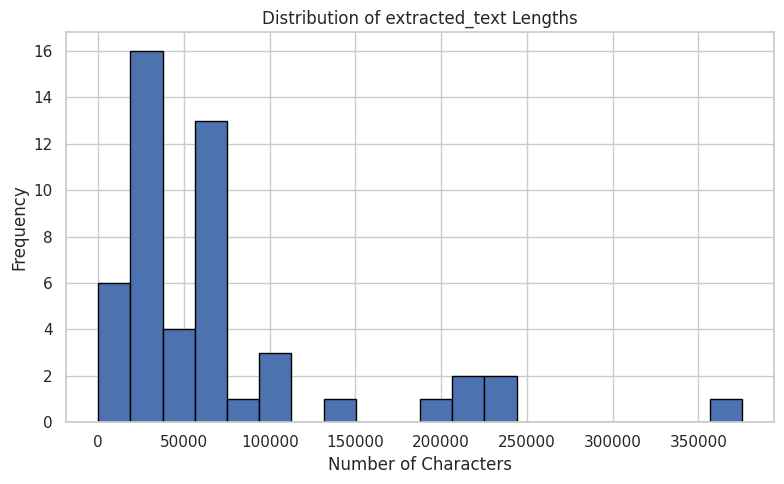

/tmp/ipython-input-4112407560.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='publication_type', data=df, order=sorted(df['publication_type'].unique()), palette='Set2')


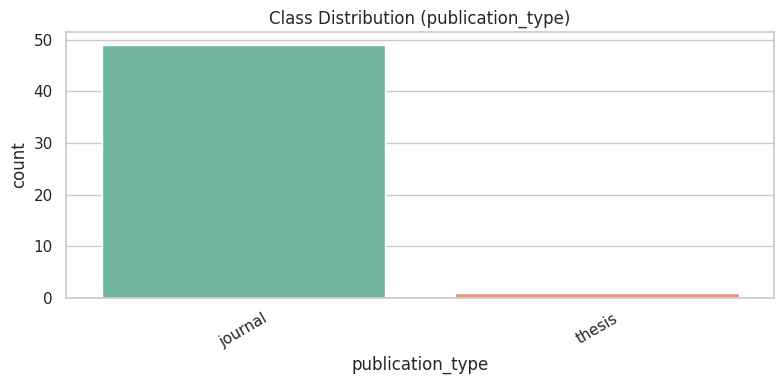

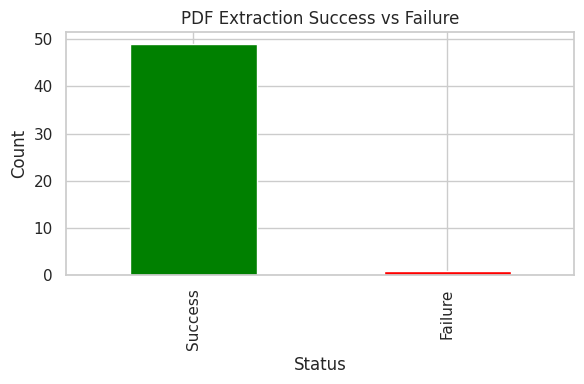


--- Summary of Initial Findings ---
📊 Total records processed: 50
✅ Successful text extractions: 49
❌ Failed / empty extractions: 1
ℹ️ extracted_text length ranges from 13 to 375360 characters

📌 Top 10 Most Frequent Words:
metadata: 1824
research: 1696
study: 1623
were: 1465
data: 1437
information: 1261
learning: 1104
used: 1096
library: 1067
digital: 1062


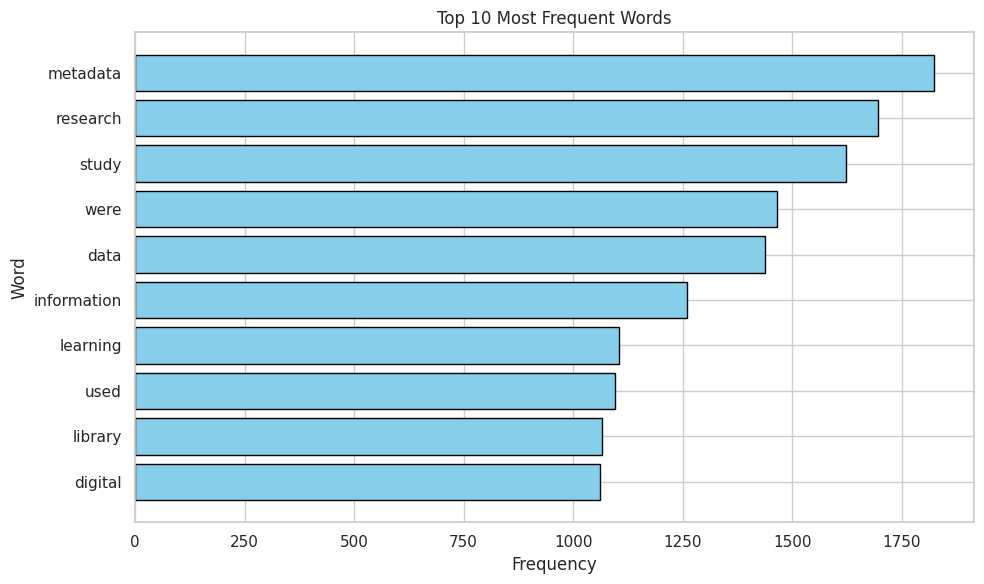

,reference_text,publication_type
0,No text found,journal
1,THE NATIONAL ASSEMBLY OF ZAMBIA\nSTRATEGIC\nPL...,journal
2,Automatic Classification of Digital Objects fo...,journal
3,Improved Discoverability of Digital Objects in...,journal
4,25th International Symposium on Electronic The...,journal


In [10]:
# Data Understanding — load + integrated EDA (CSV from MyDrive project folder)
import os, re, string, sys, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from collections import Counter
sns.set_theme(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import joblib

# Detect Colab and mount Google Drive
IN_COLAB = 'google.colab' in sys.modules
try:
    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print('Drive mount note:', e)

# Resolve the target project folder inside MyDrive
mydrive_root = '/content/drive/MyDrive' if IN_COLAB else os.path.expanduser('~/Google Drive/MyDrive')
project_dir = os.path.join(mydrive_root, 'misc-unza25-csc4792-project_team30')

# Candidate filenames inside the project folder (prefer enriched if present)
enriched_path = os.path.join(project_dir, 'references_enriched.csv')
raw_candidates = [
    os.path.join(project_dir, 'references.csv'),
    os.path.join(project_dir, 'references.scv'),
]

# If PROJECT has a filename, prefer it inside the project folder as a raw candidate
if 'PROJECT' in globals() and isinstance(PROJECT.get('data_path', None), str):
    configured = os.path.join(project_dir, os.path.basename(PROJECT['data_path']))
    if configured not in raw_candidates:
        raw_candidates.append(configured)

DATA_PATH = None
if os.path.exists(enriched_path):
    DATA_PATH = enriched_path
else:
    for p in raw_candidates:
        if os.path.exists(p):
            DATA_PATH = p
            break

if DATA_PATH is None:
    raise FileNotFoundError(
        "Could not find 'references.csv' or 'references.scv' in MyDrive/misc-unza25-csc4792-project_team30. "
        f"Checked: {[enriched_path] + raw_candidates}"
    )

# Load
df = pd.read_csv(DATA_PATH)
print("✅ Dataset loaded successfully from:", os.path.abspath(DATA_PATH))

# Normalize header names to lower snake for matching
normalized_columns = {c: re.sub(r'[^a-z0-9]+', '_', c.strip().lower()).strip('_') for c in df.columns}
df = df.rename(columns=normalized_columns)

# Try to coalesce/derive required columns
ref_candidates = ['reference_text', 'references_text', 'reference', 'raw_reference', 'extracted_text', 'text']
type_candidates = ['publication_type', 'type', 'pub_type', 'category', 'label']

ref_col = next((c for c in ref_candidates if c in df.columns), None)
type_col = next((c for c in type_candidates if c in df.columns), None)

# If reference text still missing, attempt to join possible title/author/year columns as a fallback
if ref_col is None:
    possible_parts = [c for c in ['title','authors','author','year','journal','source','venue'] if c in df.columns]
    if possible_parts:
        warnings.warn("'reference_text' not found; building from parts: " + ", ".join(possible_parts))
        df['reference_text'] = df[possible_parts].astype(str).apply(lambda r: ' '.join([x for x in r if x and x.lower() != 'nan']), axis=1)
        ref_col = 'reference_text'

# If still missing, raise a clear error
if ref_col is None:
    raise ValueError("Missing 'reference_text' and no viable source columns (e.g., 'Extracted_Text', 'reference'). Please add one of these columns in the extraction step.")

# If publication_type missing, try to infer heuristically from reference_text (weak baseline) and warn
inferred_types = False
if type_col is None:
    inferred_types = True
    warnings.warn("'publication_type' not found; inferring from text heuristics (journal/book/thesis/conference/report/web). Please provide ground-truth labels for proper training.")
    def infer_type(s: str) -> str:
        s_low = str(s).lower()
        if any(k in s_low for k in ['journal', 'vol.', 'volume', 'issue']):
            return 'journal'
        if any(k in s_low for k in ['thesis', 'dissertation', 'phd', 'masters']):
            return 'thesis'
        if any(k in s_low for k in ['proceedings', 'conference', 'symposium', 'workshop']):
            return 'conference'
        if any(k in s_low for k in ['press', 'isbn']):
            return 'book'
        if any(k in s_low for k in ['report', 'technical report']):
            return 'report'
        if any(k in s_low for k in ['http://', 'https://', 'www.']):
            return 'web'
        return 'journal'
    df['publication_type'] = df[ref_col].apply(infer_type)
    type_col = 'publication_type'

# Ensure final required columns exist with canonical names
if ref_col != 'reference_text':
    df['reference_text'] = df[ref_col].astype(str)
if type_col != 'publication_type':
    df['publication_type'] = df[type_col].astype(str)

# Basic input sanitation
df = df.dropna(subset=['reference_text', 'publication_type']).copy()
df['reference_text'] = df['reference_text'].astype(str).str.strip()
df = df[df['reference_text'].str.len() > 0]

# Persist enriched CSV if we created/normalized required columns or inferred labels
try:
    changed = (os.path.abspath(DATA_PATH) != os.path.abspath(enriched_path)) or (ref_col != 'reference_text') or (type_col != 'publication_type') or inferred_types
    if changed:
        df_to_save = df.copy()
        # include original normalized columns if helpful for downstream analysis
        df_to_save.to_csv(enriched_path, index=False)
        print('💾 Saved enriched dataset to:', enriched_path)
except Exception as e:
    print('Note: could not persist enriched CSV:', e)

# Initial Exploration
print("\n--- HEAD ---")
display(df.head(10))

print("\n--- INFO ---")
df.info()

print("\n--- DESCRIBE ---")
display(df.describe(include='all'))

print("\n--- SHAPE ---")
print(df.shape)

print('\nNull counts (key columns):')
print(df[['reference_text','publication_type']].isnull().sum())

# Choose text column for generic EDA (prefer extracted_text if present in original)
TEXT_COL = 'extracted_text' if 'extracted_text' in df.columns else 'reference_text'

# Text length distribution on chosen text column
df['Text_Length'] = df[TEXT_COL].astype(str).str.len()
plt.figure(figsize=(8,5))
plt.hist(df['Text_Length'], bins=20, edgecolor='black')
plt.title(f"Distribution of {TEXT_COL} Lengths")
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.tight_layout(); plt.show()

# Publication type distribution
plt.figure(figsize=(8,4))
sns.countplot(x='publication_type', data=df, order=sorted(df['publication_type'].unique()), palette='Set2')
plt.title('Class Distribution (publication_type)')
plt.xticks(rotation=30)
plt.tight_layout(); plt.show()

# Status success/failure (only if extracted_text present)
status_counts = None
if 'extracted_text' in df.columns:
    def _status(x):
        return 'Success' if x not in [
            'Failed to download PDF', 'No text found', 'Error extracting text'
        ] else 'Failure'
    df['Status'] = df['extracted_text'].apply(_status)
    status_counts = df['Status'].value_counts()
    plt.figure(figsize=(6,4))
    status_counts.plot(kind='bar', color=['green','red'])
    plt.title('PDF Extraction Success vs Failure')
    plt.ylabel('Count')
    plt.tight_layout(); plt.show()

# Word-level analysis on chosen text (restrict to successes if Status computed)
if status_counts is not None:
    text_series = df.loc[df['Status'] == 'Success', 'extracted_text'].dropna().astype(str)
else:
    text_series = df[TEXT_COL].dropna().astype(str)

all_text = " ".join(text_series)
cleaned_text = re.sub(r"[^a-zA-Z\s]", "", all_text).lower()
tokens = cleaned_text.split()
stopwords = set([
    'the','and','of','to','a','in','for','is','on','with','as','by','this','an','that','are','at','from','it','be','or','was'
])
tokens = [w for w in tokens if w not in stopwords and len(w) > 2]
word_counts = Counter(tokens)
top_words = word_counts.most_common(10)

# Summary of findings
print("\n--- Summary of Initial Findings ---")
print(f"📊 Total records processed: {len(df)}")
if status_counts is not None:
    successful = status_counts.get('Success', 0)
    failed = status_counts.get('Failure', 0)
    print(f"✅ Successful text extractions: {successful}")
    print(f"❌ Failed / empty extractions: {failed}")
print(f"ℹ️ {TEXT_COL} length ranges from {df['Text_Length'].min()} to {df['Text_Length'].max()} characters")

if top_words:
    print("\n📌 Top 10 Most Frequent Words:")
    for word, freq in top_words:
        print(f"{word}: {freq}")
    # Visualize top words
    words, freqs = zip(*top_words)
    plt.figure(figsize=(10,6))
    plt.barh(list(words)[::-1], list(freqs)[::-1], color='skyblue', edgecolor='black')
    plt.title('Top 10 Most Frequent Words')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout(); plt.show()

# Keep only needed columns for next phases
# (Preserve downstream expectations for modeling)
df = df[['reference_text','publication_type']]
df.head()

## 3. Data Preparation

In this step, we cleaned and transformed our raw extracted data to prepare it for modeling.

### Data Cleaning
- Removed rows with failed/empty PDF extractions.
- Dropped duplicates and extremely short texts (<50 characters).
- Normalized whitespace and casing.

### Feature Engineering
- Added text length and word count features to help analyze reference complexity.

### Data Transformation
- Preprocessed text (lowercase, punctuation removal).
- Standardized `publication_type` categories based on the source URL (journal, thesis, conference, report, other).
- Created a new `cleaned_text` column for training.

The cleaned dataset was saved as `processed_references.csv` for use in the modeling stage.


In [11]:
# Data Preparation — clean text, split, vectorize (strict)
# Guard: ensure Data Understanding (CSV load) ran first
if 'df' not in globals():
    raise NameError("DataFrame 'df' is not defined. Run the Data Understanding cell (cell 5) first to load data from MyDrive/misc-unza25-csc4792-project-team30 (references.csv).")

# Strict check for required columns
required = {'reference_text', 'publication_type'}
missing = required - set(df.columns)
if missing:
    raise KeyError(
        "Data Preparation requires columns: reference_text, publication_type. Missing: " + ", ".join(sorted(missing)) +
        ". Fix your CSV headers and re-run DU (cell 5)."
    )

import pandas as pd
import re, string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


def clean_reference(text: str) -> str:
    if pd.isna(text):
        return ''
    t = str(text).lower()
    t = re.sub(f'[{re.escape(string.punctuation)}]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

# Create cleaned text
df['cleaned_text'] = df['reference_text'].astype(str).apply(clean_reference)
X = df['cleaned_text'].values
y = df['publication_type'].values

# Stratify only if every class has at least 2 samples
value_counts = pd.Series(y).value_counts()
can_stratify = (value_counts >= 2).all() and len(value_counts) > 1

strat = y if can_stratify else None
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=1)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

X_train_tfidf.shape, X_val_tfidf.shape

((40, 10000), (10, 10000))

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import re

HEADERS = {"User-Agent": "Mozilla/5.0"}

categories = {
    "thesis": "https://datalab.unza.zm/publications/theses-and-dissertations",
    "conference": "https://datalab.unza.zm/publications/conference-papers",
    "report": "https://datalab.unza.zm/index.php/publications/technical-reports",
    "journal": "https://datalab.unza.zm/publications/journal-articles",
}

references = []

def get_pdf_from_detail(url, pub_type):
    """Visit detail page and extract PDF link + title."""
    r = requests.get(url, headers=HEADERS)
    if r.status_code != 200:
        print(f" Failed to load detail page: {url}")
        return None
    soup = BeautifulSoup(r.text, "lxml")

    # Extract title
    title_tag = soup.find("h1")
    title = title_tag.get_text(strip=True) if title_tag else url

    # Find PDF links
    pdf_link = None
    for a in soup.find_all("a", href=True):
        if a["href"].lower().endswith(".pdf"):
            pdf_link = a["href"]
            if not pdf_link.startswith("http"):
                pdf_link = "https://datalab.unza.zm" + pdf_link
            break

    if pdf_link:
        return {
            "reference_text": title,
            "publication_type": pub_type,
            "pdf_url": pdf_link
        }
    return None

for pub_type, base_url in categories.items():
    print(f"🔎 Scraping {pub_type}")
    page = 0
    while True:
        list_url = f"{base_url}?page={page}" if "?" in base_url else f"{base_url}?page={page}"
        r = requests.get(list_url, headers=HEADERS)
        if r.status_code != 200:
            print(f" Failed to load {list_url}")
            break

        soup = BeautifulSoup(r.text, "lxml")
        more_info_links = soup.find_all("a", href=True, string=re.compile(r"More Info", re.I))

        if not more_info_links:
            break  # No more results, stop pagination

        for a in more_info_links:
            detail_url = a["href"]
            if not detail_url.startswith("http"):
                detail_url = "https://datalab.unza.zm" + detail_url
            ref = get_pdf_from_detail(detail_url, pub_type)
            if ref:
                references.append(ref)

        print(f"➡ Processed page {page}, found {len(more_info_links)} entries")
        page += 1

# Save results
df = pd.DataFrame(references)
print(f"✅ Collected {len(df)} references")
os.makedirs("data", exist_ok=True)
df.to_csv("/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references.csv", index=False)
print("💾 Saved references to data/references.csv")


🔎 Scraping thesis
➡ Processed page 0, found 10 entries
🔎 Scraping conference
➡ Processed page 0, found 10 entries
➡ Processed page 1, found 10 entries
➡ Processed page 2, found 5 entries
🔎 Scraping report
➡ Processed page 0, found 4 entries
🔎 Scraping journal
➡ Processed page 0, found 6 entries
✅ Collected 39 references
💾 Saved references to data/references.csv


In [4]:
# Data Preparation — clean text, split, vectorize (strict)
# Guard: ensure Data Understanding (CSV load) ran first
if 'df' not in globals():
    raise NameError("DataFrame 'df' is not defined. Run the Data Understanding cell (cell 5) first to load data from MyDrive/misc-unza25-csc4792-project_team30 (references.csv).")

# Strict check for required columns
required = {'reference_text', 'publication_type'}
missing = required - set(df.columns)
if missing:
    raise KeyError(
        "Data Preparation requires columns: reference_text, publication_type. Missing: " + ", ".join(sorted(missing)) +
        ". Fix your CSV headers and re-run DU (cell 5)."
    )

import pandas as pd
import re, string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


def clean_reference(text: str) -> str:
    if pd.isna(text):
        return ''
    t = str(text).lower()
    t = re.sub(f'[{re.escape(string.punctuation)}]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

# Create cleaned text
df['cleaned_text'] = df['reference_text'].astype(str).apply(clean_reference)
X = df['cleaned_text'].values
y = df['publication_type'].values

# Stratify only if every class has at least 2 samples
value_counts = pd.Series(y).value_counts()
can_stratify = (value_counts >= 2).all() and len(value_counts) > 1

strat = y if can_stratify else None
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=1)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

X_train_tfidf.shape, X_val_tfidf.shape

KeyError: 'reference_text'

In [ ]:
# -----------------------------
# Step 2: Feature Engineering
# -----------------------------
# Add length-based features
data["char_length"] = data["reference_text"].str.len()
data["word_count"] = data["reference_text"].str.split().str.len()

print("\nFeature sample:")
print(data[["char_length", "word_count"]].head())



Feature sample:
   char_length  word_count
0           99          14
1          130          17
2          112          15
3           98          13
4           84          12


# Step 3: Data Transformation

In [ ]:
# -----------------------------
# Step 3: Data Transformation
# -----------------------------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)  # keep only letters
    text = re.sub(r"\s+", " ", text).strip()
    return text

data["cleaned_text"] = data["reference_text"].apply(clean_text)

# Standardize publication types based on PDF URL
def map_pub_type(url):
    url = str(url).lower()
    if "journal" in url:
        return "journal"
    elif "conference" in url:
        return "conference"
    elif "thesis" in url or "theses" in url:
        return "thesis"
    elif "report" in url or "technical-report" in url:
        return "report"
    else:
        return "other"

data["publication_type_mapped"] = data["pdf_url"].apply(map_pub_type)

print("\nDistribution after mapping:")
print(data["publication_type_mapped"].value_counts())

# Save cleaned and transformed data
os.makedirs("/content/drive/MyDrive/misc-unza25-csc4792-project_team30/data", exist_ok=True)
data.to_csv("/content/drive/MyDrive/misc-unza25-csc4792-project_team30/data/references_cleaned.csv", index=False)
print("💾 Saved cleaned and transformed references to data/references_cleaned.csv")

KeyError: 'reference_text'

# Step 4: Save Processed Data

In [ ]:
# -----------------------------
# Step 4: Save Processed Data
# -----------------------------
processed_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/processed_references.csv"
data[["cleaned_text", "publication_type"]].to_csv(processed_path, index=False)

print(f"\n💾 Saved processed dataset to {processed_path}")


💾 Saved processed dataset to /content/drive/MyDrive/misc-unza25-csc4792-project_team30/processed_references.csv


# Evaluation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
print(os.listdir("/content/drive/MyDrive"))

Mounted at /content/drive
['lab2 (1)', 'lab2', 'Classroom', 'Quiz 1.pdf.PDF', 'Scan 06 May 22 · 05·56·39.pdf(1).PDF', 'downloadfile.pdf.PDF', 'Quiz 4.pdf', 'Quiz 5.pdf', 'VID-20220830-WA0024.mp4', '16630541047835507050548719143658.pdf', '2912 Q2.PDF', '20220913_153003.jpg', 'SALES_CO_DB.SQL', 'Questions2Answer.gdoc', 'CSC2202_Partial_CA.gdoc', 'CSC3301', 'Class Exercise 1. (CSC3712).gdoc', 'Class Exercise 1. (CSC3712).pdf', 'Untitled document (1).gdoc', 'Class Exercise 2.gdoc', 'A.I Individual report .gdoc', 'A.I Individual report .pdf', 'CSC 4631', 'Maintenance Plan.gdoc', 'Desktop - home.png', 'Desktop - Services.png', 'Phone - Services.png', 'Phone - Contact (1).png', 'Phone - Contact.png', 'Phone - home.png', 'Desktop - contact.png', 'Hospital Management System', 'Feasibility Study.gdoc', 'Untitled document.gdoc', 'Broiler Farm Management System (1).pptx', 'Broiler Farm Management System.pptx', 'modeler-skeleton-main.zip', 'CSC 3402 Reading Assingmets.gdoc', 'Exercise 1.gdoc', 'LLM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

X = df.drop("FinalResult", axis=1)
y = df["FinalResult"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

if len(y.unique()) == 2:
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_lebel=y.unique()[1])
    roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc: .2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



NameError: name 'df' is not defined